In [1]:
import time
notebook_start_time = time.perf_counter()

# GalNAc data annotation statistics

## Imports

### Built-in imports

In [2]:
import math
import gzip
import pickle
import re
from pathlib import Path
from collections import Counter
from itertools import chain

### Shared library imports

In [3]:
import glyc_processing.annotation
from glyc_processing.misc import split_uniprot_id

### External imports

In [4]:
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
from matplotlib import pyplot as plt
from IPython.display import display

## Paths & Constants

In [5]:
#BASE_DIR = Path("/mnt/g/My Drive/CloudVault/Masters/Data")
BASE_DIR = Path("/home/jakob/Cloudvault_new/Data")

# Path of exported annotations file
ANNOTATIONS_FILE = BASE_DIR/'NetOGlyc5 data'/'GalNAc data'/'04-annotation'/'protein_annotations.pkl.gz'

# Path of directory to get Graphpart output
GRAPHPART_DIR = BASE_DIR/'NetOGlyc5 data'/'GalNAc data'/'06-partitioning'/'graphpart_partitions'

# Path of exported protein sequences fasta files
PROTEIN_SEQS_FILE = BASE_DIR/'NetOGlyc5 data'/'GalNAc data'/'05-embedding'/'protein_seqs.fasta'

# The amino acids that are allowed to be glycosylated
ALLOWED_AA = ('S','T','Y')

# Maximum sequence length that can be embedded in one go
# 1022 for BERT/ALBERT (ESM-1b / ProtBert wo. start/end tokens), No limit for XLNet
MAX_SEQ_LENGTH = 1022
#MAX_SEQ_LENGTH = 7000

# Which of the following partitions to look at: training, validation and training proteins
USE_PARTITIONS = ['training', 'validation', 'testing']

In [6]:
GRAPHPART_OUTPUT_FILE = GRAPHPART_DIR/'graphpart_output.csv'

## Fetch protein annotations

In [7]:
with gzip.open(ANNOTATIONS_FILE, 'rb') as f:
    proteins = pickle.load(f)

## Fetch validation/testing partition IDs

In [8]:
clusters = [set(), set(), set()]
with open(GRAPHPART_OUTPUT_FILE, 'r') as f:
    f_iter = iter(f)
    header = next(f_iter).strip().split(',')
    for line in f_iter:
        AC, priority, glycosylated, cluster = line.strip().split(',')
        priority = priority == "True"
        glycosylated = float(glycosylated) > 0
        cluster = int(float(cluster))
        clusters[cluster].add(AC)

In [9]:
[len(cluster) for cluster in clusters]

[2139, 268, 267]

In [10]:
validation_ids = clusters[1]
testing_ids = clusters[2]
training_ids = set(proteins) - validation_ids - testing_ids

### Look only at some partitions if specified

In [11]:
if 'training' not in USE_PARTITIONS:
    for protein_id in training_ids:
        del proteins[protein_id]

if 'validation' not in USE_PARTITIONS:
    for protein_id in validation_ids:
        del proteins[protein_id]
        
if 'testing' not in USE_PARTITIONS:
    for protein_id in testing_ids:
        del proteins[protein_id]

## Data Statistics

### Protein Stats

In [12]:
isoforms_dict = {}
for uniprot_id in proteins:
    protein_id, isoform_id = split_uniprot_id(uniprot_id)
    if protein_id not in isoforms_dict:
        isoforms_dict[protein_id] = [isoform_id]
    else:
        isoforms_dict[protein_id].append(isoform_id)

isoform_proteins = {protein_id: isoforms_list for protein_id, isoforms_list in isoforms_dict.items() if isoforms_list != [None]}
multi_isoform_proteins = {protein_id: isoforms_list for protein_id, isoforms_list in isoforms_dict.items() if len(isoforms_list) > 1}

print(f"Con-canonical protein isoforms: {len(isoform_proteins)} ({len(isoform_proteins)/len(proteins)*100:.2f}%)")
print(f"Multi-isoform proteins: {len(isoform_proteins)} ({len(multi_isoform_proteins)/len(proteins)*100:.2f}%)")

Con-canonical protein isoforms: 0 (0.00%)
Multi-isoform proteins: 0 (0.00%)


### Effects of truncation

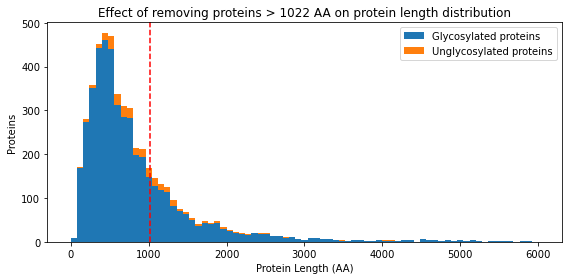

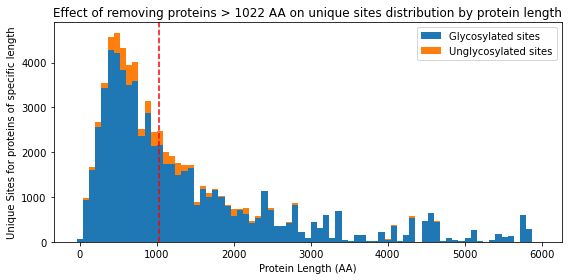

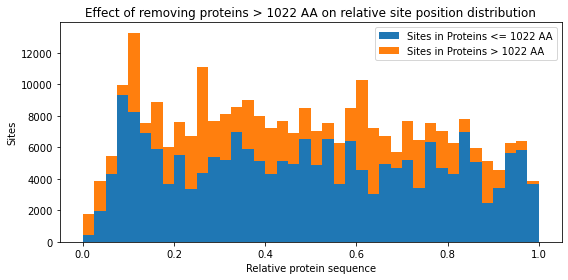

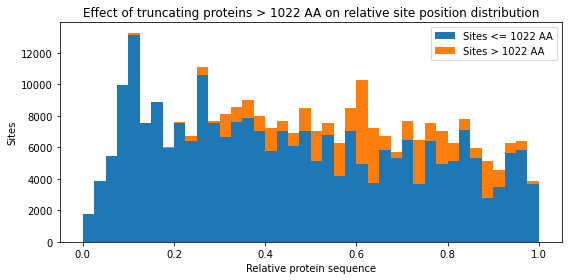

% of proteins seen in dataset that are too long to be fully embedded (>1022 AA): 1266 (25.35%)
% of seen possible sites that are found in in too long proteins (>1022 AA): 34263 (47.38%)
% of seen possible sites that are found in in parts of proteins beyond 1022 AA: 15352 (21.23%)
Explanation: If the last value is close to 0%, we can throw away the proteins that are very long. Otherwise, we either need to embed long proteins in chunks and stitch them together, truncate long proteins or use a model with a higher max embedding length


In [13]:
max_plot_length = 6000
plot_bins = 75

protein_lengths = {uniprot_id: len(proteins[uniprot_id].protein_seq) for uniprot_id in proteins}
glycosylated_protein_lengths = {uniprot_id: len(proteins[uniprot_id].protein_seq) for uniprot_id in proteins if len(proteins[uniprot_id].sites) > 0}
unglycosylated_protein_lengths = {uniprot_id: len(proteins[uniprot_id].protein_seq) for uniprot_id in proteins if len(proteins[uniprot_id].sites) == 0}

bins = np.arange(0, max_plot_length+max_plot_length/plot_bins, max_plot_length/plot_bins) # fixed bin size
fig, ax = plt.subplots(figsize=(8,4))
ax.hist([list(glycosylated_protein_lengths.values()), list(unglycosylated_protein_lengths.values())], bins=bins, stacked=True, width=max_plot_length/plot_bins, label=("Glycosylated proteins", "Unglycosylated proteins"))
ax.axvline(x=MAX_SEQ_LENGTH, color='red', linestyle='--')
ax.set_title(f'Effect of removing proteins > {MAX_SEQ_LENGTH} AA on protein length distribution')
ax.set_xlabel('Protein Length (AA)')
ax.set_ylabel('Proteins')
ax.legend()
fig.tight_layout()
plt.show(block=False)

too_long_proteins = {uniprot_id for uniprot_id in protein_lengths if protein_lengths[uniprot_id] > MAX_SEQ_LENGTH}
n_too_long_protein_sites = 0
n_all_sites = 0
for protein in proteins.values():
    for i in range(len(protein.protein_seq)):
        if protein.seq_sites[i] is not None and protein.seq_idx_seen_count[i] > 0:
            n_all_sites += 1
            if protein.protein_id in too_long_proteins:
                n_too_long_protein_sites += 1

protein_seen_site_count = {}
protein_too_high_index_seen_site_count = {}
for protein in proteins.values():
    for i in range(len(protein.protein_seq)):
        if protein.seq_sites[i] is not None and protein.seq_idx_seen_count[i] > 0:
            if protein.protein_id not in protein_seen_site_count:
                protein_seen_site_count[protein.protein_id] = 0
                protein_too_high_index_seen_site_count[protein.protein_id] = 0
            protein_seen_site_count[protein.protein_id] += 1
            if i >= MAX_SEQ_LENGTH:
                protein_too_high_index_seen_site_count[protein.protein_id] += 1
n_too_high_index_sites = sum(protein_too_high_index_seen_site_count.values())

glycosylated_protein_lengths, glycosylated_site_counts = zip(*((protein_lengths[uniprot_id], protein_seen_site_count[uniprot_id]) for uniprot_id in glycosylated_protein_lengths))
unglycosylated_protein_lengths, unglycosylated_site_counts = zip(*((protein_lengths[uniprot_id], protein_seen_site_count[uniprot_id]) for uniprot_id in unglycosylated_protein_lengths))

bins = np.arange(0, max_plot_length+max_plot_length/plot_bins, max_plot_length/plot_bins)
glycosylated_bar_heights, _ = np.histogram(glycosylated_protein_lengths, bins=bins, weights=glycosylated_site_counts)
unglycosylated_bar_heights, _ = np.histogram(unglycosylated_protein_lengths, bins=bins, weights=unglycosylated_site_counts)
fig, ax = plt.subplots(figsize=(8,4))
ax.bar(bins[:-1], glycosylated_bar_heights, width=max_plot_length/plot_bins, label="Glycosylated sites")
ax.bar(bins[:-1], unglycosylated_bar_heights, bottom=glycosylated_bar_heights, width=max_plot_length/plot_bins, label="Unglycosylated sites")
ax.axvline(x=MAX_SEQ_LENGTH, color='red', linestyle='--')
ax.set_title(f'Effect of removing proteins > {MAX_SEQ_LENGTH} AA on unique sites distribution by protein length')
ax.set_xlabel('Protein Length (AA)')
ax.set_ylabel('Unique Sites for proteins of specific length')
ax.legend()
fig.tight_layout()
plt.show(block=False)

fully_embeddable_protein_relative_site_positions = []
too_long_protein_relative_site_positions = []
partly_embeddable_site_relative_positions = []
too_long_site_relative_positions = []
for protein in proteins.values():
    for site in protein.sites:
        relative_site_position = sum(site.possible_site_indices)/site.count/len(protein.protein_seq)
        if len(protein.protein_seq) < MAX_SEQ_LENGTH:
            fully_embeddable_protein_relative_site_positions.append(relative_site_position)
        else:
            too_long_protein_relative_site_positions.append(relative_site_position)
        if site.possible_site_indices[0] <= MAX_SEQ_LENGTH:
            partly_embeddable_site_relative_positions.append(relative_site_position)
        else:
            too_long_site_relative_positions.append(relative_site_position)

bins = np.arange(0, 1+1/40, 1/40)
fig, ax = plt.subplots(figsize=(8,4))
ax.hist([fully_embeddable_protein_relative_site_positions, too_long_protein_relative_site_positions], bins=bins, stacked=True, label=(f"Sites in Proteins <= {MAX_SEQ_LENGTH} AA", f"Sites in Proteins > {MAX_SEQ_LENGTH} AA"))
ax.set_title(f'Effect of removing proteins > {MAX_SEQ_LENGTH} AA on relative site position distribution')
ax.set_xlabel('Relative protein sequence')
ax.set_ylabel(f'Sites')
ax.legend()
fig.tight_layout()
plt.show(block=False)

bins = np.arange(0, 1+1/40, 1/40)
fig, ax = plt.subplots(figsize=(8,4))
ax.hist([partly_embeddable_site_relative_positions, too_long_site_relative_positions], bins=bins, stacked=True, label=(f"Sites <= {MAX_SEQ_LENGTH} AA", f"Sites > {MAX_SEQ_LENGTH} AA"))
ax.set_title(f'Effect of truncating proteins > {MAX_SEQ_LENGTH} AA on relative site position distribution')
ax.set_xlabel('Relative protein sequence')
ax.set_ylabel(f'Sites')
ax.legend()
fig.tight_layout()
plt.show(block=False)

#fig.tight_layout()
#fig.subplots_adjust(top=0.9)
#fig.suptitle("Effects of long protein removal/truncation on distributions", fontsize=16)
#plt.show(block=False)

print(f"% of proteins seen in dataset that are too long to be fully embedded (>{MAX_SEQ_LENGTH} AA): {len(too_long_proteins)} ({len(too_long_proteins)/len(protein_lengths)*100:.2f}%)")
print(f"% of seen possible sites that are found in in too long proteins (>{MAX_SEQ_LENGTH} AA): {n_too_long_protein_sites} ({n_too_long_protein_sites/n_all_sites*100:.2f}%)")
print(f"% of seen possible sites that are found in in parts of proteins beyond {MAX_SEQ_LENGTH} AA: {n_too_high_index_sites} ({n_too_high_index_sites/n_all_sites*100:.2f}%)")
print("Explanation: If the last value is close to 0%, we can throw away the proteins that are very long. Otherwise, we either need to embed long proteins in chunks and stitch them together, truncate long proteins or use a model with a higher max embedding length")

In [14]:
total_glyc_proteins = 0
total_glyc_sites = 0
nonglyc_proteins_by_truncation = {}
for protein in proteins.values():
    max_seq_length = min(len(protein.protein_seq), MAX_SEQ_LENGTH)
    if len(protein.sites) > 0:
        included_glyc_sites = [idx for idx, sites in enumerate(protein.seq_sites[:max_seq_length]) if sites is not None and len(sites) > 0]
        excluded_glyc_sites = [idx for idx, sites in enumerate(protein.seq_sites[max_seq_length:]) if sites is not None and len(sites) > 0]
        total_glyc_sites += len(protein.sites)
        total_glyc_proteins += 1
        if len(included_glyc_sites) == 0:
            nonglyc_proteins_by_truncation[protein.protein_id] = excluded_glyc_sites

print(f"Glycosylated proteins with no remaining possible glycosylation sites after truncation: {len(nonglyc_proteins_by_truncation)} ({len(nonglyc_proteins_by_truncation)/total_glyc_proteins*100:.2f}%)")
print(f"Possible glycosylated sites lost after truncation: {sum(len(sites) for sites in nonglyc_proteins_by_truncation.values())} ({sum(len(sites) for sites in nonglyc_proteins_by_truncation.values())/total_glyc_sites*100:.2f}%)")

Glycosylated proteins with no remaining possible glycosylation sites after truncation: 260 (5.55%)
Possible glycosylated sites lost after truncation: 1580 (0.55%)


In [15]:
n_sites = 0
non_glyc_proteins = {}
glyc_proteins_nonglyc = {}
glyc_proteins = {}
certain_glyc_proteins = {}
comp_glyc_proteins = {}
comp_certain_glyc_proteins = {}

for protein in proteins.values():
    protein_id = protein.protein_id
    protein_len = len(protein.protein_seq)

    glycosylation_labels = np.array(protein.get_glycosylation_labels(end=protein_len))
    
    sites_compositions = np.zeros(protein_len)
    for idx, sites in enumerate(protein.seq_sites[:protein_len]):
        if sites is not None and len(sites) > 0:
            for site in sites:
                if 'site_composition' in site.site_annotations and pd.notna(site.site_annotations['site_composition']):
                    sites_compositions[idx] = 1

    sites_mask = glycosylation_labels >= 0
    n_sites += sites_mask.sum()

    glyc_sites_mask = glycosylation_labels > 0
    if glyc_sites_mask.sum() > 0:
        glyc_proteins[protein_id] = np.where(glyc_sites_mask)[0]

    non_glyc_sites_mask = glycosylation_labels == 0
    if glyc_sites_mask.sum() == 0:
        non_glyc_proteins[protein_id] = np.where(non_glyc_sites_mask)[0]
    else:
        glyc_proteins_nonglyc[protein_id] = np.where(non_glyc_sites_mask)[0]

    certain_glyc_sites_mask = glycosylation_labels == 1
    if certain_glyc_sites_mask.sum() > 0:
        certain_glyc_proteins[protein_id] = np.where(certain_glyc_sites_mask)[0]

    if sites_compositions.sum() > 0:
        comp_glyc_proteins[protein_id] = np.where(sites_compositions)[0]

        comp_certain_glyc_sites_mask = sites_compositions.astype(bool) & certain_glyc_sites_mask
        if comp_certain_glyc_sites_mask.sum() > 0:
            comp_certain_glyc_proteins[protein_id] = np.where(comp_certain_glyc_sites_mask)[0]

trunc_n_sites = 0
trunc_non_glyc_proteins = {}
trunc_glyc_proteins_nonglyc = {}
trunc_glyc_proteins = {}
trunc_certain_glyc_proteins = {}
trunc_comp_glyc_proteins = {}
trunc_comp_certain_glyc_proteins = {}

for protein in proteins.values():
    protein_id = protein.protein_id
    protein_len = min(len(protein.protein_seq), MAX_SEQ_LENGTH)

    glycosylation_labels = np.array(protein.get_glycosylation_labels(end=protein_len))
    
    sites_compositions = np.zeros(protein_len)
    for idx, sites in enumerate(protein.seq_sites[:protein_len]):
        if sites is not None and len(sites) > 0:
            for site in sites:
                if 'site_composition' in site.site_annotations and pd.notna(site.site_annotations['site_composition']):
                    sites_compositions[idx] = 1

    sites_mask = glycosylation_labels >= 0
    trunc_n_sites += sites_mask.sum()

    glyc_sites_mask = glycosylation_labels > 0
    if glyc_sites_mask.sum() > 0:
        trunc_glyc_proteins[protein_id] = np.where(glyc_sites_mask)[0]

    non_glyc_sites_mask = glycosylation_labels == 0
    if glyc_sites_mask.sum() == 0:
        trunc_non_glyc_proteins[protein_id] = np.where(non_glyc_sites_mask)[0]
    else:
        trunc_glyc_proteins_nonglyc[protein_id] = np.where(non_glyc_sites_mask)[0]

    certain_glyc_sites_mask = glycosylation_labels == 1
    if certain_glyc_sites_mask.sum() > 0:
        trunc_certain_glyc_proteins[protein_id] = np.where(certain_glyc_sites_mask)[0]

    if sites_compositions.sum() > 0:
        trunc_comp_glyc_proteins[protein_id] = np.where(sites_compositions)[0]

        comp_certain_glyc_sites_mask = sites_compositions.astype(bool) & certain_glyc_sites_mask
        if comp_certain_glyc_sites_mask.sum() > 0:
            trunc_comp_certain_glyc_proteins[protein_id] = np.where(comp_certain_glyc_sites_mask)[0]

print(f"Before Truncation -> After Truncation to {MAX_SEQ_LENGTH} AA:\n")
            
print(f"Proteins: {len(proteins)}")
print(f"\tNon-glycosylated Proteins: {len(non_glyc_proteins)}->{len(trunc_non_glyc_proteins)} ({len(non_glyc_proteins)/len(proteins)*100:.2f}%->{len(trunc_non_glyc_proteins)/len(proteins)*100:.2f}%)")
print(f"\tGlycosylated Proteins: {len(glyc_proteins)}->{len(trunc_glyc_proteins)} ({len(glyc_proteins)/len(proteins)*100:.2f}%->{len(trunc_glyc_proteins)/len(proteins)*100:.2f}%)")
print(f"\t\tGlycosylated Proteins w. (at least 1) Composition: {len(comp_glyc_proteins)}->{len(trunc_comp_glyc_proteins)} ({len(comp_glyc_proteins)/len(proteins)*100:.2f}%->{len(trunc_comp_glyc_proteins)/len(proteins)*100:.2f}%)")
print(f"\t\tGlycosylated Proteins w. (at least 1) Un-ambiguous site: {len(certain_glyc_proteins)}->{len(trunc_certain_glyc_proteins)} ({len(certain_glyc_proteins)/len(proteins)*100:.2f}%->{len(trunc_certain_glyc_proteins)/len(proteins)*100:.2f}%)")
print(f"\t\t\tProteins w. (at least 1) Un-ambiguous site and Composition: {len(comp_certain_glyc_proteins)}->{len(trunc_comp_certain_glyc_proteins)} ({len(comp_certain_glyc_proteins)/len(proteins)*100:.2f}%->{len(trunc_comp_certain_glyc_proteins)/len(proteins)*100:.2f}%)")
print()

non_glyc_proteins_non_glyc_sites = sum(len(non_glyc_proteins[protein_id]) for protein_id in non_glyc_proteins)
glyc_proteins_non_glyc_sites = sum(len(glyc_proteins_nonglyc[protein_id]) for protein_id in glyc_proteins_nonglyc)
glyc_sites = sum(len(glyc_proteins[protein_id]) for protein_id in glyc_proteins)
certain_glyc_sites = sum(len(certain_glyc_proteins[protein_id]) for protein_id in certain_glyc_proteins)
comp_glyc_sites = sum(len(comp_glyc_proteins[protein_id]) for protein_id in comp_glyc_proteins)
comp_certain_glyc_sites = sum(len(comp_certain_glyc_proteins[protein_id]) for protein_id in comp_certain_glyc_proteins)

trunc_non_glyc_proteins_non_glyc_sites = sum(len(trunc_non_glyc_proteins[protein_id]) for protein_id in trunc_non_glyc_proteins)
trunc_glyc_proteins_non_glyc_sites = sum(len(trunc_glyc_proteins_nonglyc[protein_id]) for protein_id in trunc_glyc_proteins_nonglyc)
trunc_glyc_sites = sum(len(trunc_glyc_proteins[protein_id]) for protein_id in trunc_glyc_proteins)
trunc_certain_glyc_sites = sum(len(trunc_certain_glyc_proteins[protein_id]) for protein_id in trunc_certain_glyc_proteins)
trunc_comp_glyc_sites = sum(len(trunc_comp_glyc_proteins[protein_id]) for protein_id in trunc_comp_glyc_proteins)
trunc_comp_certain_glyc_sites = sum(len(trunc_comp_certain_glyc_proteins[protein_id]) for protein_id in trunc_comp_certain_glyc_proteins)

print(f"Sites (Glycosylated and Non-glycosylated): {n_sites}->{trunc_n_sites}")
print(f"\tNon-glycosylated Sites: {glyc_proteins_non_glyc_sites+non_glyc_proteins_non_glyc_sites}->{trunc_glyc_proteins_non_glyc_sites+trunc_non_glyc_proteins_non_glyc_sites} ({(glyc_proteins_non_glyc_sites+non_glyc_proteins_non_glyc_sites)/n_sites*100:.2f}%->{(trunc_glyc_proteins_non_glyc_sites+trunc_non_glyc_proteins_non_glyc_sites)/trunc_n_sites*100:.2f}%)")
print(f"\t\tNon-glycosylated Sites in Glycosylated Proteins: {glyc_proteins_non_glyc_sites}->{trunc_glyc_proteins_non_glyc_sites} ({glyc_proteins_non_glyc_sites/n_sites*100:.2f}%->{trunc_glyc_proteins_non_glyc_sites/trunc_n_sites*100:.2f}%)")
print(f"\t\tNon-glycosylated Sites in Non-glycosylated Proteins: {non_glyc_proteins_non_glyc_sites}->{trunc_non_glyc_proteins_non_glyc_sites} ({non_glyc_proteins_non_glyc_sites/n_sites*100:.2f}%->{trunc_non_glyc_proteins_non_glyc_sites/trunc_n_sites*100:.2f}%)")
print(f"\tGlycosylated Sites: {glyc_sites}->{trunc_glyc_sites} ({glyc_sites/n_sites*100:.2f}%->{trunc_glyc_sites/trunc_n_sites*100:.2f}%)")
print(f"\t\tGlycosylated Sites w. Composition: {comp_glyc_sites}->{trunc_comp_glyc_sites} ({comp_glyc_sites/n_sites*100:.2f}%->{trunc_comp_glyc_sites/trunc_n_sites*100:.2f}%)")
print(f"\t\tNon-ambiguous Glycosylated Sites: {certain_glyc_sites}->{trunc_certain_glyc_sites} ({certain_glyc_sites/n_sites*100:.2f}%->{trunc_certain_glyc_sites/trunc_n_sites*100:.2f}%)")
print(f"\t\t\tNon-ambiguous Glycosylated Sites w. Composition: {comp_certain_glyc_sites}->{trunc_comp_certain_glyc_sites} ({comp_certain_glyc_sites/n_sites*100:.2f}%->{trunc_comp_certain_glyc_sites/trunc_n_sites*100:.2f}%)")

Before Truncation -> After Truncation to 1022 AA:

Proteins: 4995
	Non-glycosylated Proteins: 311->571 (6.23%->11.43%)
	Glycosylated Proteins: 4684->4424 (93.77%->88.57%)
		Glycosylated Proteins w. (at least 1) Composition: 4191->3936 (83.90%->78.80%)
		Glycosylated Proteins w. (at least 1) Un-ambiguous site: 2910->2679 (58.26%->53.63%)
			Proteins w. (at least 1) Un-ambiguous site and Composition: 2874->2645 (57.54%->52.95%)

Sites (Glycosylated and Non-glycosylated): 72322->56970
	Non-glycosylated Sites: 38953->28915 (53.86%->50.75%)
		Non-glycosylated Sites in Glycosylated Proteins: 33594->22458 (46.45%->39.42%)
		Non-glycosylated Sites in Non-glycosylated Proteins: 5359->6457 (7.41%->11.33%)
	Glycosylated Sites: 33369->28055 (46.14%->49.25%)
		Glycosylated Sites w. Composition: 24158->20035 (33.40%->35.17%)
		Non-ambiguous Glycosylated Sites: 6581->5535 (9.10%->9.72%)
			Non-ambiguous Glycosylated Sites w. Composition: 6537->5494 (9.04%->9.64%)


### Stats after truncation

In [16]:
glyc_sites_count = 0
nonglyc_sites_count = 0
for protein in proteins.values():
    for idx, count in enumerate(protein.seq_idx_seen_count[:MAX_SEQ_LENGTH]):
        if count > 0 and protein.seq_sites[idx] is not None:
            if len(protein.seq_sites[idx]) > 0:
                glyc_sites_count += 1
            else:
                nonglyc_sites_count += 1

total_sites_count = glyc_sites_count+nonglyc_sites_count

print(f"Total sites:{total_sites_count}")  
print(f"Glycosylated sites:\t{glyc_sites_count}\t{glyc_sites_count/total_sites_count*100:.2f}% (weight: {total_sites_count/(2*glyc_sites_count)})")
print(f"Non-glycosylated sites:\t{nonglyc_sites_count}\t{nonglyc_sites_count/total_sites_count*100:.2f}% (weight: {total_sites_count/(2*nonglyc_sites_count)})")

Total sites:56970
Glycosylated sites:	28055	49.25% (weight: 1.0153270361789342)
Non-glycosylated sites:	28915	50.75% (weight: 0.9851288258689261)


In [17]:
allowed_sites_seen_ratio = []
seen_sites_glyc_ratio = []
for protein in proteins.values():
    allowed_sites = [i for i in range(len(protein.protein_seq[:MAX_SEQ_LENGTH])) if protein.seq_sites[i] is not None]
    seen_sites_count = sum(1 for i in allowed_sites if protein.seq_idx_seen_count[i] > 0)
    glycosylated_sites_count = sum(1 for i in allowed_sites if len(protein.seq_sites[i]) > 0)
    if glycosylated_sites_count > 0:
        allowed_sites_seen_ratio.append(seen_sites_count/len(allowed_sites))
        seen_sites_glyc_ratio.append(glycosylated_sites_count/seen_sites_count)

allowed_sites_seen_ratio_mean = sum(allowed_sites_seen_ratio)/len(allowed_sites_seen_ratio)
seen_sites_glyc_ratio_mean = sum(seen_sites_glyc_ratio)/len(seen_sites_glyc_ratio)

print(f"mean % per protein of possible sites that are seen in data (only for glycosylated proteins): {allowed_sites_seen_ratio_mean*100:.2f}%")
print(f"mean % per protein of seen sites that are glycosylated (only for glycosylated proteins): {seen_sites_glyc_ratio_mean*100:.2f}%")
print("Explanation: 1st value can be considered coverage depth of data, 2nd should be as close to 50% as possible")

mean % per protein of possible sites that are seen in data (only for glycosylated proteins): 12.79%
mean % per protein of seen sites that are glycosylated (only for glycosylated proteins): 69.49%
Explanation: 1st value can be considered coverage depth of data, 2nd should be as close to 50% as possible


In [18]:
seen_nonglycosylated_sites = {aa: 0 for aa in ALLOWED_AA}
glycosylated_sites = {aa: 0 for aa in ALLOWED_AA}

for protein in proteins.values():
    for i, sites in enumerate(protein.seq_sites[:MAX_SEQ_LENGTH]):
        if sites is not None:
            site_aa = protein.protein_seq[i]
            if len(sites) > 0:
                glycosylated_sites[site_aa] += 1
            else:
                if protein.seq_idx_seen_count[i] > 0:
                    seen_nonglycosylated_sites[site_aa] += 1

imbalance_fractions = {aa: max(glycosylated_sites[aa], seen_nonglycosylated_sites[aa])/min(glycosylated_sites[aa], seen_nonglycosylated_sites[aa])-1 for aa in ALLOWED_AA}
imbalance_percentages = {aa: f'{imbalance_fractions[aa]*100:.2f}%' for aa in imbalance_fractions}

sites_needed = {aa: abs(glycosylated_sites[aa]-seen_nonglycosylated_sites[aa]) for aa in ALLOWED_AA}

print(f"Seen glycosylated sites: {glycosylated_sites}")
print(f"Seen non-glycosylated sites: {seen_nonglycosylated_sites}")
print(f"Imbalance percentages: {imbalance_percentages}")
print(f"Needed sites to balance out data: {sites_needed}")
print("Explanation: Imbalance should be as close to 0 as possible for all AA. check for each AA if positive or negative data is needed")

Seen glycosylated sites: {'S': 14343, 'T': 11492, 'Y': 2220}
Seen non-glycosylated sites: {'S': 15257, 'T': 9674, 'Y': 3984}
Imbalance percentages: {'S': '6.37%', 'T': '18.79%', 'Y': '79.46%'}
Needed sites to balance out data: {'S': 914, 'T': 1818, 'Y': 1764}
Explanation: Imbalance should be as close to 0 as possible for all AA. check for each AA if positive or negative data is needed


In [19]:
nonambiguous_site_count = 0
ambiguous_site_count = 0
for protein in proteins.values():
    trunc_sites = set()
    for sites in protein.seq_sites[:MAX_SEQ_LENGTH]:
        if sites is not None:
            trunc_sites.update(sites)
    for site in trunc_sites:
        if site.count == 1:
            nonambiguous_site_count += 1
        else:
            ambiguous_site_count += 1

total_site_count = nonambiguous_site_count + ambiguous_site_count

print(f"Nonambiguous sites: {nonambiguous_site_count} {nonambiguous_site_count/total_site_count*100:.2f}%")
print(f"Ambiguous sites: {ambiguous_site_count} {ambiguous_site_count/total_site_count*100:.2f}%")
print("Explanation: The percentage of Nonambiguous sites can be considered as the quality of the MS peptide data")

Nonambiguous sites: 157882 63.84%
Ambiguous sites: 89419 36.16%
Explanation: The percentage of Nonambiguous sites can be considered as the quality of the MS peptide data


In [20]:
sugar_encoding_order = [
    'HexNAc',
    'HexHexNAc',
    'Hex',
    'Sia',
    'dHex',
    'NeuAc',
    'NeuGc',
]

def split_site_composition(site_composition):
    sugars = []
    for comp in re.findall(r'[1-9][0-9]*x[A-Za-z]+', site_composition):
        count, sugar = comp.split('x', 1)
        count = int(count)
        sugars.extend([sugar] * count)
    return sugars

site_composition_count = 0
site_count = 0
site_compositions = set()
sugar_counter = Counter()
for protein in proteins.values():
    trunc_sites = set()
    for sites in protein.seq_sites[:MAX_SEQ_LENGTH]:
        if sites is not None:
            trunc_sites.update(sites)
    for site in trunc_sites:
        if 'site_composition' in site.site_annotations and pd.notna(site.site_annotations['site_composition']):
            site_composition_count += 1
            site_compositions.add(site.site_annotations['site_composition'])
            sugar_counter.update(split_site_composition(site.site_annotations['site_composition']))
        site_count += 1

sugar_total_count = sum(sugar_counter.values())

print(f"% of sites that have site composition info: {site_composition_count/site_count*100:.2f}%")
print(f"Site composition sugar distribution:")
print('\n'.join(f"{sugar}:\t{count}\t{count/sugar_total_count*100:.2f}% (weight: {sugar_total_count/(len(site_compositions)*count)})" for sugar, count in sugar_counter.most_common()))

% of sites that have site composition info: 71.82%
Site composition sugar distribution:
HexNAc:	139007	71.74% (weight: 0.016207565923148256)
HexHexNAc:	45469	23.47% (weight: 0.04954947582482724)
Hex:	5485	2.83% (weight: 0.4107502490937228)
Sia:	2659	1.37% (weight: 0.8472979000673447)
dHex:	609	0.31% (weight: 3.699450108832627)
NeuAc:	500	0.26% (weight: 4.505930232558139)
NeuGc:	26	0.01% (weight: 86.65250447227191)


In [21]:
notebook_end_time = time.perf_counter()
print(f"Notebook took {notebook_end_time-notebook_start_time} seconds to run")

Notebook took 9.263697604066692 seconds to run
